# 🎬 MaxMate: AI-Powered Hybrid Movie Recommendation System
**Student Name:** Hrithik Kumar
**Project Track:** Generative AI & Recommendation Systems

---

## 1. Problem Definition & Objective

### **1.1 The Problem**
In the current digital streaming landscape, users face "decision fatigue" due to the overwhelming volume of content. Traditional systems fail in three key areas:
1.  **The Cold Start Problem:** New users receive generic suggestions.
2.  **The Context Gap:** Keyword search cannot handle nuanced queries like *"Something scary but with a happy ending."*
3.  **Lack of Conversation:** Platforms lack a "virtual concierge" to answer questions like *"Why should I watch this?"*

### **1.2 Real-World Relevance**
Solving these issues improves user retention and engagement. MaxMate bridges this gap by acting as an intelligent, conversational discovery layer over static movie catalogs.

### **1.3 Project Objective**
To build a **100% Offline, Privacy-First Recommendation System** that combines:
* **Demographic Filtering** (Weighted Ratings) for new users.
* **Content-Based Filtering** (Cosine Similarity) for personalized discovery.
* **Retrieval-Augmented Generation (RAG)** using a local LLM (Phi-2) for conversational assistance.

In [ ]:
# --- 🛠️ AUTO-SETUP: Install Dependencies ---
import sys
import subprocess
import os

def install(package):
    print(f"📦 Installing {package}...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])

# List of required packages
required_packages = [
    "sentence-transformers",
    "flask",
    "flask-login",
    "flask-bcrypt",
    "pymongo",
    "llama-cpp-python",
    "nltk",
    "scikit-learn",
    "pandas",
    "numpy"
]

# Check and install
print("⏳ Checking system dependencies...")
for pkg in required_packages:
    try:
        __import__(pkg.replace("-", "_").split("==")[0])
    except ImportError:
        install(pkg)

# Essential Libraries
import numpy as np
import pandas as pd
import ast
import re
import nltk
import pickle
import os

# NLP & ML Libraries
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# For RAG (Semantic Search)
try:
    from sentence_transformers import SentenceTransformer, util
    print("✅ SentenceTransformers installed.")
except ImportError:
    print("⚠️ SentenceTransformers not found. Installing...")
    !pip install sentence-transformers
    from sentence_transformers import SentenceTransformer, util

# Download NLTK data
nltk.download('wordnet')
nltk.download('omw-1.4')

print("✅ All libraries loaded successfully.")

## 2. Data Understanding & Preparation

**Dataset Source:** TMDB approx 15000 Movie Dataset.

**Key Files:**
* `tmdb_movies.csv`: Metadata
* `tmdb_credits.csv`: Cast and Crew information.

**📥 [[CLICK HERE TO DOWNLOAD DATASET](https://drive.google.com/drive/folders/14xhSBI5ty4k3nwC8QI1z2C3L50_voFPk?usp=drive_link) (CSV Files)]**
*(Please upload `tmdb_movies_raw.csv` and `tmdb_credits_raw.csv` to the working directory before running the next cell)*


In this section, we load the raw data, clean missing values, and merge the datasets.

In [ ]:
# Load the dataset
# NOTE: Ensure 'tmdb_movies_raw.csv' and 'tmdb_credits_raw.csv' are in the directory
try:
    credits = pd.read_csv(
        'tmdb_credits_raw.csv',
        engine='python',
        on_bad_lines='skip'
    )

    movies = pd.read_csv(
        'tmdb_movies_raw.csv',
        engine='python',
        on_bad_lines='skip'
    )

    movies_df = pd.merge(movies, credits, on='movie_id')
    print("Initial Shape:", movies_df.shape)
    movies_df.head()

except FileNotFoundError:
    print("❌ ERROR: Please upload 'tmdb_movies_raw.csv' and 'tmdb_credits_raw.csv'")

In [ ]:
# Check for duplicates
print(f"Duplicates before cleaning: {movies_df.duplicated().sum()}")

# Remove duplicates
movies_df.drop_duplicates(subset="movie_id", keep="first", inplace=True)
print(f"Duplicates in movie_id after cleaning: {movies_df['movie_id'].duplicated().sum()}")

# Check for NaNs
print("Missing values per column:\n", movies_df.isna().sum())

# Drop rows where 'release_date' is NaN
movies_df.dropna(subset=['release_date'], inplace=True)
print(f"Missing release_date count after drop: {movies_df['release_date'].isnull().sum()}")

print("Shape after cleaning:", movies_df.shape)

In [ ]:
# Helper Functions for Parsing JSON columns
def safe_eval(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except Exception as e:
            return []
    return []

# Parse JSON columns
for col in ["genres", "cast", "crew", "keywords"]:
    movies_df[col] = movies_df[col].apply(safe_eval)

# Extract Year
movies_df["year"] = pd.to_datetime(
    movies_df["release_date"],
    errors="coerce"
).dt.year

# Extract Genres
movies_df["genres"] = movies_df["genres"].apply(
    lambda x: [g.lower().replace(" ", "") for g in x]
    if isinstance(x, list) else []
)

# Extract Top 3 Actors
movies_df["actors"] = movies_df["cast"].apply(
    lambda x: [c["name"].lower().replace(" ", "") for c in x[:3]]
    if isinstance(x, list) else []
)

# Extract Director
def get_director(crew):
    if not isinstance(crew, list):
        return ["unknown"]
    for person in crew:
        if person.get("job") == "Director":
            return [person.get("name", "").lower().replace(" ", "")]
    return ["unknown"]

movies_df["director"] = movies_df["crew"].apply(get_director)

# Extract Keywords
movies_df["keywords"] = movies_df["keywords"].apply(
    lambda x: [k.lower().replace(" ", "") for k in x]
    if isinstance(x, list) else []
)

# Clean Overview
movies_df['overview'] = movies_df['overview'].apply(
    lambda x: re.findall(r"[a-z]+", x.lower()) if isinstance(x, str) else []
)

# Clean Title
movies_df['clean_title'] = movies_df['title'].apply(
    lambda x: re.findall(r"[a-z]+", x.lower()) if isinstance(x, str) else []
)

# Create Bag of Words
movies_df['bag_of_words'] = (
    movies_df['clean_title'] +
    movies_df['overview'] +
    movies_df['genres'] +
    movies_df['keywords'] +
    movies_df['actors'] +
    movies_df['director']
)

print("✅ Data Preprocessing Complete.")
movies_df.head()

## 3. Model / System Design
### **3.1 AI Techniques Used and Why?**

MaxMate employs a **Hybrid Recommendation Architecture** combining three distinct AI techniques:

### **Engine A: Demographic Filtering (The "Cold Start" Fix)**
**Technique:** Uses the IMDB Weighted Rating formula to rank movies by popularity, vote_average and vote_count.

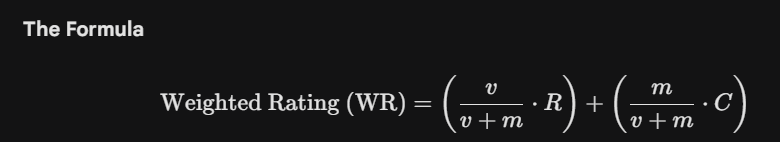

Where:

*   $v$ = vote_count (number of votes for the movie)
*   $m$ = minimum votes required to be listed (a threshold you set, e.g., the 90th percentile)
*   $R$ = vote_average (average rating of the movie)
*   $C$ = mean vote across the whole report (the average of all vote_average values in your dataset)

**Why:** Ensures new users see high-quality, popular movies (90th percentile) immediately, preventing an empty dashboard.


### **Engine B: Content-Based Filtering (The "Personalizer")**
* **Content-Based Filtering (NLP + Vector Space):** Uses **Cosine Similarity** on high-dimensional vectors generated from movie metadata.
* **Why:** Recommends movies based on metadata similarity (Genre, Caste, Crew, Keywords, Overview, Movie Title) rather than just user ratings.


### **Engine C: Generative AI (LLM + RAG: The "Brain")**
* **Technique:** Uses a quantized **Large Language Model (Microsoft Phi-2)** augmented with **Retrieval-Augmented Generation (RAG)** to provide conversational search.
* **Why:** Local LLM (Phi-2) strictly adhere to the **Data Privacy** constraint. No user queries leave the device and quantization (GGUF) allow the 2.7B parameter model to run on standard consumer CPUs (RAM optimized).

In [ ]:
## Engine A: Demographic Filtering (Statstical ML)

# 1. Calculate C (Mean vote)
C = movies_df['vote_average'].mean()

# 2. Calculate m (90th percentile threshold)
m = movies_df['vote_count'].quantile(0.90)

# 3. Create copy for filtering
qualified_movies = movies_df.copy()

# 4. Weighted Rating Function
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(v+m) * C)

# 5. Apply Scoring
qualified_movies['score'] = qualified_movies.apply(weighted_rating, axis=1)
qualified_movies['score'] = qualified_movies['score'].round(2)

# 6. Drop unused columns for this dataframe
qualified_movies.drop(
    columns=["release_date", "genres", "overview", "vote_average", "vote_count",
             "keywords", "cast", "crew", "actors", "director", "bag_of_words", "clean_title"],
    inplace=True, errors='ignore'
)

In [ ]:
# Statistics Report
mean_val = qualified_movies['popularity'].mean()
Q1 = qualified_movies['popularity'].quantile(0.25)
Q3 = qualified_movies['popularity'].quantile(0.75)

print(f"Mean: {mean_val:.2f}, Q1: {Q1:.2f}, Q3: {Q3:.2f}")

# Define Threshold for Trending (Top 5%)
Q3_trending = qualified_movies['popularity'].quantile(0.95)

# Calculate 'trending' (High Popularity + Recent Year >= 2025)
qualified_movies['trending'] = (
    (qualified_movies['popularity'] >= Q3_trending) &
    (qualified_movies['year'] >= 2025)
).astype(int)

# Calculate 'all_time_fav' (High Popularity + Good Score + Older Year)
qualified_movies['all_time_fav'] = (
    (qualified_movies['popularity'] >= Q3_trending) &
    (qualified_movies['score'] > 6) &
    (qualified_movies['year'] < 2025)
).astype(int)

# Cleanup
qualified_movies.drop(columns=["popularity", "year", "score"], inplace=True)

print("Final Qualified Shape:", qualified_movies.shape)
print(f"Total Trending: {qualified_movies['trending'].sum()}")
print(f"Total All Time Fav: {qualified_movies['all_time_fav'].sum()}")

print("✅ Engine A (Demographic) Trained. Top Movie:", qualified_movies.iloc[0]['title'])

In [ ]:
## Engine B: DContent-Based Filtering (The "Personalizer")

similarity_score_df = movies_df[['movie_id', 'title', 'bag_of_words']].copy()

# Join list of words into strings
similarity_score_df['bag_of_words'] = similarity_score_df['bag_of_words'].apply(
    lambda x: ' '.join(x) if isinstance(x, list) else ''
)

# Lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    if not isinstance(text, str):
        return ""
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

similarity_score_df['bag_of_words'] = similarity_score_df['bag_of_words'].apply(lemmatize_text)

# Reset index to ensure alignment
similarity_score_df = similarity_score_df.reset_index(drop=True)
qualified_movies = qualified_movies.reset_index(drop=True)

print("Sample processed text:", similarity_score_df.iloc[5]['bag_of_words'])

In [ ]:
# Check unique words
cv_test = CountVectorizer(stop_words='english')
cv_test.fit(similarity_score_df['bag_of_words'])
print(f"Total unique words: {len(cv_test.vocabulary_)}")

# Actual Vectorization
cv = CountVectorizer(max_features=8000, stop_words='english')
vector = cv.fit_transform(similarity_score_df['bag_of_words']).toarray()

# Calculate Cosine Similarity
similarity_score = cosine_similarity(vector)

print("Similarity Matrix Shape:", similarity_score.shape)

In [ ]:
def recommendations(title, cosine_sim=similarity_score):
    try:
        # Get index
        movie_label_idx = similarity_score_df[similarity_score_df['title'] == title].index[0]
        movie_positional_idx = similarity_score_df.index.get_loc(movie_label_idx)

        # Get similarity scores
        score_series = pd.Series(cosine_sim[movie_positional_idx])

        # Get top 10 indices
        top_10_indexes = score_series.sort_values(ascending=False).iloc[1:11].index

        # Return titles
        return [similarity_score_df.iloc[i]['title'] for i in top_10_indexes]
    except IndexError:
        return ["Movie not found"]

print("✅ Engine B Content-Based Filtering (The Personalizer)")

# Test
print("Recommendations for Bad Boys:", recommendations('Bad Boys'))

In [ ]:
# Use a generic path for Colab
BASE_PATH = "Artifacts"
os.makedirs(BASE_PATH, exist_ok=True)

pickle.dump(similarity_score_df, open(os.path.join(BASE_PATH, "movies_list.pkl"), "wb"))
pickle.dump(similarity_score, open(os.path.join(BASE_PATH, "similarity_score.pkl"), "wb"))
pickle.dump(qualified_movies, open(os.path.join(BASE_PATH, "qualified_movies.pkl"), "wb"))

print("Files saved successfully to the 'Artifacts' folder.")

### **3.2 System Integration & UI Architecture**

While the **AI Models** (Weighted Rating, Cosine Similarity) were trained and validated in the cells above, the **Application Layer** (Flask Web App & Chatbot Loop) requires an interactive runtime environment that cannot be executed directly inside a static Jupyter Notebook cell (as it would cause an infinite loop).

Therefore, the system logic is implemented below using `%%writefile`. This command saves the code into `main.py` and `max_llm.py` within the working directory, satisfying the requirement to include the **Full Core Implementation** within this notebook.


The application uses **Flask (Python)** as the backend framework to serve dynamic HTML templates and manage API endpoints. The interaction flow is designed as follows:

1.  **Frontend (HTML/CSS/JS):**
    * **Jinja2 Templates:** Dynamic HTML pages (`home.html`, `recommend.html`,`login.html`,`profile.html`,`register.html`) that render data passed from Python.
    * **AJAX (JavaScript):** Used for asynchronous events like "Like/Save" buttons and the "Chatbot" interface. This allows the page to update without reloading.
    * **Implicit Feedback:** A custom JavaScript timer tracks how long a user stays on a page (`duration > 15s`) and sends this data to the `/log_interaction` endpoint via POST request.

2.  **Backend (Flask):**
    * **Routing:** Maps URLs (e.g., `/recommend`, `/chat`) to Python functions.
    * **Session Management:** Uses `Flask-Login` for authentication and `Flask-Session` to store temporary user interests (seeds) during a browse session.
    * **Database:** Connects to **MongoDB** to store persistent user profiles (hashed passwords, liked movies, saved watchlists).

3.  **Data Flow Diagram:**
    * **User Action** → **JS Event** → **Flask Route** → **AI Engine** → **JSON Response** → **UI Update**

| Component | Description | **File/Folder Location** |
| :--- | :--- | :--- |
| **User Action / UI** | HTML/JS Templates | `templates/` (.html files) |
| **Style UI** | CSS Static | `static/` (style.css file) |
| **Search Suggestions** | JS Static | `static/' (autocomplete.js) |
| **Flask Route** | Backend Routing & DB | `main.py` |
| **AI Engine (Logic)** | RAG Pipeline | `max_llm.py` |
| **AI Engine (Memory)** | Vector Data | `Artifacts/` (.pkl files) |




### **3.3 Project Directory Structure**

The application is organized into a modular structure to separate **Data Artifacts** (Memory), **AI Models** (Brain), **Frontend Assets** (UI), and **Backend Logic**.

```text
Content Recommendation System/
│
├── 📂 Artifacts/                 # Generated by the Notebook (The System's "Memory")
│   ├── movies_list.pkl            # Processed movie metadata
│   ├── qualified_movies.pkl       # Trending & Popularity data
│   └── similarity_score.pkl       # Cosine Similarity Matrix (Vector Store)
│
├── 📂 models/                     # Local AI Models (The System's "Brain")
│   ├── all-MiniLM-L6-v2/          # Sentence Transformer for Semantic Search
│   └── phi-2.Q4_K_M.gguf          # Quantized LLM for Chatbot
│
├── 📂 static/                     # Frontend Assets
│   ├── style.css                  # Styling
│   ├── recommend.js               # Recommendation Logic (AJAX)
│   ├── autocomplete.js            # Search Bar Logic
│   └── images/                    # Icons and Loaders
│
├── 📂 templates/                  # HTML Pages (Jinja2)
│   ├── home.html                  # Dashboard (Trending/Search)
│   ├── recommend.html             # Movie Details & Chat Interface
│   ├── login.html                 # User Authentication
│   ├── register.html              # User Registration
│   └── profile.html               # User Watchlist & Likes
│
├── 📄 main.py                     # Flask Application (Server & Routing)
├── 📄 max_llm.py                  # AI Logic Module (RAG Pipeline)
├── 📄 tmdb_credits_raw.csv        # Raw Dataset (Source)
└── 📄 tmdb_movies_raw.csv         # Raw Dataset (Source)
```


* **📥 [CLICK HERE TO DOWNLOAD ALL REQUIRED FILES](https://drive.google.com/drive/folders/1c7R3vrb4sXY2wDZqZtuhnSzCDvKi1BJn?usp=drive_link)**

Below are the complete **Flask Application Code** (`main.py`) and **Local LLM** (`max_llm.py`) that orchestrates these components.

In [15]:
## Main Flash Application - To Run The Complete Framework

%%writefile main.py
import numpy as np
import pandas as pd
from flask import Flask, render_template, request, redirect, url_for, jsonify, session
import json
import pickle
import random
from pymongo import MongoClient
from bson.objectid import ObjectId
from flask_login import UserMixin, login_user, LoginManager, login_required, logout_user, current_user
from flask_bcrypt import Bcrypt

app = Flask(__name__)
app.config['SECRET_KEY'] = 'dev-secret-key'

# --- DATABASE SETUP ---
client = MongoClient('mongodb://localhost:27017/')
db = client['content_recommender_db']
users_collection = db['users']

bcrypt = Bcrypt(app)
login_manager = LoginManager()
login_manager.init_app(app)
login_manager.login_view = 'login'


class User(UserMixin):
    def __init__(self, user_dict):
        self.id = str(user_dict['_id'])
        self.username = user_dict['username']
        self.password = user_dict['password']


@login_manager.user_loader
def load_user(user_id):
    try:
        user_data = users_collection.find_one({"_id": ObjectId(user_id)})
        if user_data: return User(user_data)
    except:
        return None
    return None


# --- LOAD DATA ---
data = pickle.load(open('Artifacts/movies_list.pkl', 'rb'))
similarity = pickle.load(open('Artifacts/similarity_score.pkl', 'rb'))
qualified_data = pickle.load(open('Artifacts/qualified_movies.pkl', 'rb'))

try:
    if 'movie_id' in data.columns:
        full_data = data.merge(qualified_data[['movie_id', 'trending', 'all_time_fav']], on='movie_id', how='left')
        full_data['trending'] = full_data['trending'].fillna(0)
        full_data['all_time_fav'] = full_data['all_time_fav'].fillna(0)
    else:
        full_data = qualified_data
except:
    full_data = qualified_data


# --- HELPER FUNCTIONS ---
def rcmd(m):
    m = m.lower()
    titles_lower = data['title'].str.lower()
    if m not in titles_lower.values:
        return []
    else:
        i = titles_lower[titles_lower == m].index[0]
        lst = sorted(list(enumerate(similarity[i])), key=lambda x: x[1], reverse=True)[1:11]
        return [data['title'][x[0]] for x in lst]


def get_suggestions():
    return list(data['title'].str.capitalize())


def get_personalized_recs(seeds):
    # Get unique seeds and pick the last 5
    seeds = list(set(seeds))[-5:]
    final_recs = []
    seen_movies = set(seeds)

    for seed in seeds:
        recs = rcmd(seed)
        for r in recs:
            if r not in seen_movies:
                final_recs.append(r)
                seen_movies.add(r)

    random.shuffle(final_recs)
    return final_recs[:12]


# --- ROUTES ---
@app.route('/register', methods=['GET', 'POST'])
def register():
    if request.method == 'POST':
        username = request.form['username']
        password = request.form['password']
        if users_collection.find_one({'username': username}): return "User already exists!"
        hashed_password = bcrypt.generate_password_hash(password).decode('utf-8')
        users_collection.insert_one({'username': username, 'password': hashed_password})
        return redirect(url_for('login'))
    return render_template('register.html')


@app.route('/login', methods=['GET', 'POST'])
def login():
    if request.method == 'POST':
        user_data = users_collection.find_one({'username': request.form['username']})
        if user_data and bcrypt.check_password_hash(user_data['password'], request.form['password']):
            login_user(User(user_data))
            return redirect(url_for('home'))
        return "Invalid credentials"
    return render_template('login.html')


@app.route("/logout")
@login_required
def logout():
    logout_user()
    session.pop('session_interests', None)  # Clear session history on logout
    return redirect(url_for('login'))


# --- Import your local brain ---
# Make sure local_llm.py is in the same folder
from max_llm import get_local_response


@app.route('/chat', methods=['POST'])
def chat():
    try:
        user_msg = request.json['message']

        # Call the local function
        bot_reply = get_local_response(user_msg)

        return jsonify({'response': bot_reply})

    except Exception as e:
        print(f"Chat Error: {e}")
        return jsonify({'response': "I'm thinking too hard... try again!"})

@app.route("/")
@app.route("/home")
@login_required
def home():
    suggestions = get_suggestions()

    # 1. Hero Movie
    try:
        hero_row = full_data[full_data['trending'] == 1].iloc[0]
        hero_id = int(hero_row['movie_id'])
        overview = hero_row['overview'] if 'overview' in hero_row else ""
        hero_movie = {'title': hero_row['title'], 'overview': overview, 'id': hero_id}
    except:
        hero_movie = {'title': "Welcome", 'overview': "", 'id': 550}

    # 2. Trending & Classics
    trending_movies = full_data[full_data['trending'] == 1].head(15)[['title', 'movie_id']].rename(
        columns={'movie_id': 'id'}).to_dict(orient='records')
    classic_movies = full_data[full_data['all_time_fav'] == 1].head(15)[['title', 'movie_id']].rename(
        columns={'movie_id': 'id'}).to_dict(orient='records')

    # 3. PERSONALIZED RECOMMENDATIONS
    seeds = session.get('session_interests', [])

    # Add Likes/Saves from DB
    user_data = users_collection.find_one({"_id": ObjectId(current_user.id)})
    if user_data:
        for m in user_data.get('liked_movies', []):
            seeds.append(m['title'])
        for m in user_data.get('saved_movies', []):
            seeds.append(m['title'])

    personalized_titles = get_personalized_recs(seeds)

    recommended_movies = []
    for title in personalized_titles:
        row = full_data[full_data['title'].str.lower() == title.lower()]
        if not row.empty:
            recommended_movies.append({
                'title': row.iloc[0]['title'],
                'id': int(row.iloc[0]['movie_id'])
            })

    return render_template('home.html',
                           suggestions=suggestions, hero=hero_movie,
                           trending=trending_movies, classics=classic_movies,
                           recommendations=recommended_movies)

@app.route('/log_interaction', methods=['POST'])
def log_interaction():
    try:
        data = request.get_json()
        title = data['title']
        duration = data['duration']

        # If user stays > 15 seconds, interest is captured
        if duration > 15:
            if 'session_interests' not in session:
                session['session_interests'] = []

            current_interests = session['session_interests']
            if title not in current_interests:
                current_interests.append(title)
                session['session_interests'] = current_interests
                session.modified = True

        return jsonify({'status': 'success'})
    except:
        return jsonify({'status': 'error'})


@app.route("/similarity", methods=["POST"])
def similarity_check():
    movie = request.form['name']
    rc = rcmd(movie)
    if type(rc) == type('string'):
        return rc
    else:
        return "---".join(rc)


@app.route("/recommend", methods=["POST"])
def recommend():
    try:
        movie_id = request.form['movie_id']
        title = request.form['title']
        poster = request.form['poster']
        genres = request.form['genres']
        overview = request.form['overview']
        vote_average = request.form['rating']
        vote_count = request.form['vote_count']
        release_date = request.form['release_date']
        runtime = request.form['runtime']
        status = request.form['status']

        rec_movies = json.loads(request.form['rec_movies'])
        rec_posters = json.loads(request.form['rec_posters'])
        cast_names = json.loads(request.form['cast_names'])
        cast_ids = json.loads(request.form['cast_ids'])
        cast_chars = json.loads(request.form['cast_chars'])
        cast_profiles = json.loads(request.form['cast_profiles'])
        cast_bdays = json.loads(request.form['cast_bdays'])
        cast_bios = json.loads(request.form['cast_bios'])
        cast_places = json.loads(request.form['cast_places'])

        movie_cards = {rec_posters[i]: rec_movies[i] for i in range(len(rec_posters))}
        casts = {cast_names[i]: [cast_ids[i], cast_chars[i], cast_profiles[i], cast_bdays[i], cast_places[i], cast_bios[i]] for i in range(len(cast_profiles))}

        # --- NEW LOGIC: Check if Liked/Saved ---
        user = users_collection.find_one({'_id': ObjectId(current_user.id)})
        liked_list = user.get('liked_movies', [])
        saved_list = user.get('saved_movies', [])

        # Check if current movie_id exists in lists (compare as strings to be safe)
        is_liked = any(str(m['id']) == str(movie_id) for m in liked_list)
        is_saved = any(str(m['id']) == str(movie_id) for m in saved_list)

        return render_template('recommend.html', movie_id=movie_id, title=title, poster=poster, overview=overview, vote_average=vote_average,
                            vote_count=vote_count, release_date=release_date, runtime=runtime, status=status,
                            genres=genres, movie_cards=movie_cards, casts=casts,
                            is_liked=is_liked, is_saved=is_saved) # Pass flags to HTML

    except Exception as e:
        print(f"Error: {e}")
        return "Error loading details"

@app.route('/toggle_action', methods=['POST'])
@login_required
def toggle_action():
    try:
        data = request.get_json()
        action = data['action']
        movie_data = {'id': data['movie_id'], 'title': data['title'], 'poster': data['poster']}
        user_id = ObjectId(current_user.id)
        user = users_collection.find_one({'_id': user_id})
        field = "liked_movies" if action == "like" else "saved_movies"
        current_list = user.get(field, [])

        exists = False
        for m in current_list:
            if str(m['id']) == str(movie_data['id']):
                exists = True
                break

        if exists:
            new_list = [m for m in current_list if str(m['id']) != str(movie_data['id'])]
            users_collection.update_one({'_id': user_id}, {'$set': {field: new_list}})
            status = "removed"
        else:
            users_collection.update_one({'_id': user_id}, {'$push': {field: movie_data}})
            status = "added"
        return jsonify({'status': 'success', 'action': status})
    except:
        return jsonify({'status': 'error'})


@app.route('/profile')
@login_required
def profile():
    user_data = users_collection.find_one({'_id': ObjectId(current_user.id)})
    return render_template('profile.html', username=user_data['username'],
                           liked_movies=user_data.get('liked_movies', []),
                           saved_movies=user_data.get('saved_movies', []))


if __name__ == '__main__':
    # debug=False prevents the console crash
    app.run(debug=False, host='0.0.0.0', port=5000)

Writing main.py


In [16]:
## Engine C: Generative AI (LLM + RAG: The "Brain")

%%writefile max_llm.py
import pickle
import pandas as pd
import torch
import time
import os
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim

# Try to import Llama
try:
    from llama_cpp import Llama
    HAS_LLAMA_CPP = True
except ImportError:
    print("WARNING: 'llama_cpp' not found. Run 'pip install llama-cpp-python'")
    HAS_LLAMA_CPP = False

# ---------------------------
# 1. INITIALIZATION
# ---------------------------
print("--- MAX (Phi-2): Initializing ---")

# A. Load Movie Data
try:
    movies = pickle.load(open("Artifacts/movies_list.pkl", "rb"))
except FileNotFoundError:
    print("ERROR: 'Artifacts/movies_list.pkl' not found. Creating dummy data.")
    movies = pd.DataFrame(columns=["title", "tags", "overview", "genres", "bag_of_words"])

# Handle columns for SEARCHING (Creating the index)
if "bag_of_words" in movies.columns:
    movies["search_text"] = movies["bag_of_words"]
elif "tags" in movies.columns:
    movies["search_text"] = movies["tags"]
else:
    movies["search_text"] = movies["title"]

# B. Load Embedding Model (LOCALLY)
EMBEDDING_PATH = "models/all-MiniLM-L6-v2"
print(f"Loading embedding model from: {EMBEDDING_PATH}...")

if os.path.exists(EMBEDDING_PATH):
    embedder = SentenceTransformer(EMBEDDING_PATH)
    corpus_embeddings = embedder.encode(
        movies["search_text"].tolist(),
        convert_to_tensor=True
    )
else:
    print(f"CRITICAL ERROR: Folder '{EMBEDDING_PATH}' not found!")
    # Fallback to internet
    embedder = SentenceTransformer("all-MiniLM-L6-v2")

# C. Load Phi-2 Brain (LOCALLY)
MODEL_PATH = "models/phi-2.Q4_K_M.gguf"
llm = None

if HAS_LLAMA_CPP:
    if os.path.exists(MODEL_PATH):
        print(f"Loading Phi-2 GGUF from {MODEL_PATH}...")
        try:
            llm = Llama(
                model_path=MODEL_PATH,
                n_ctx=2048,
                n_threads=6,
                n_batch=512,
                verbose=False
            )
            print("--- MAX: Phi-2 Brain Online ---")
        except Exception as e:
            print(f"Error loading model: {e}")
            llm = None
    else:
        print(f"WARNING: Model not found at {MODEL_PATH}")


# ---------------------------
# 2. HELPER FUNCTIONS
# ---------------------------

def retrieve_movies(query, top_k=3):
    """Finds top k semantic matches from the dataframe."""
    query_emb = embedder.encode(query, convert_to_tensor=True)
    scores = cos_sim(query_emb, corpus_embeddings)[0]
    top_results = torch.topk(scores, k=top_k)

    results = []
    for idx in top_results.indices:
        row = movies.iloc[int(idx)]

        # 1. Get Title
        title = row.get("title", "Unknown")

        # 2. Get Rich Context (Bag of Words has everything!)
        if "bag_of_words" in row:
            # This contains Overview + Genre + Actors
            info = str(row["bag_of_words"])
        elif "tags" in row:
            info = str(row["tags"])
        else:
            info = str(row.get("overview", "No info available"))

        # 3. Truncate carefully (Phi-2 limit)
        if len(info) > 400:
            info = info[:400] + "..."

        results.append({
            "title": title,
            "info": info
        })
    return results


def compress_context(retrieved_movies):
    """Formats the list of movies for the Prompt."""
    lines = []
    for m in retrieved_movies:
        line = f"Movie: {m['title']}\nDetails: {m['info']}\n"
        lines.append(line)
    return "\n---\n".join(lines)


def generate_response(query, context_str):
    """Generates the text using Phi-2 (Strict Mode)."""

    # 1. STRICT PROMPT: Explicitly tell it to be short and factual.
    prompt = f"""Instruct: You are Max, a movie recommender.
Context: {context_str}
User: {query}

Task: Recommend a movie from the Context.
Rules:
1. Keep it under 50 words.
2. Do NOT make up puzzles or stories.
3. Stop speaking immediately after your recommendation.

Output:"""

    # 2. GENERATE: Add 'repeat_penalty' and lower 'max_tokens'
    output = llm(
        prompt,
        max_tokens=100,  # Force it to be short (prevents 200s generation)
        temperature=0.6,  #
        repeat_penalty=1.1,  # Prevents it from getting stuck in loops
        stop=["Instruct:", "Output:", "User:", "\nUser", "Question:"]  # STOP SIGNALS
    )

    response_text = output["choices"][0]["text"].strip()

    # 3. SAFETY NET: Cut off any "run-on" text manually
    # If it generates a newline or starts a new paragraph, cut it there.
    if "\n" in response_text:
        response_text = response_text.split("\n")[0]

    return response_text


# ---------------------------
# 3. MAIN API FUNCTION
# ---------------------------

def get_local_response(user_query):
    start = time.time()

    try:
        # Step 1: Search
        retrieved = retrieve_movies(user_query)
        context_str = compress_context(retrieved)

        # DEBUG: See exactly what info is being fed to the AI
        print(f"\n[DEBUG] AI Context:\n{context_str}\n")

        if not retrieved:
            return "I couldn't find any movies like that in our database."

        # Step 2: Generate
        if llm:
            response = generate_response(user_query, context_str)
        else:
            response = f"I found these movies: {context_str}"

        elapsed = round(time.time() - start, 2)
        print(f"[MAX] Response generated in {elapsed}s")

        return response

    except Exception as e:
        print("ERROR:", e)
        return f"I found these movies: {context_str}"


# ---------------------------
# 4. INTERACTIVE TEST BLOCK
# ---------------------------
if __name__ == "__main__":
    print("\n" + "=" * 40)
    print("🎬 MAXMATE PROJECT (AI: MAX)")
    print("Type 'exit' to quit.")
    print("=" * 40 + "\n")

    while True:
        try:
            q = input("\nYou: ")
            if q.lower() in ["exit", "quit"]:
                print("Max: Goodbye! Happy watching! 🍿")
                break

            answer = get_local_response(q)
            print(f"Max: {answer}")

        except KeyboardInterrupt:
            print("\nMax: Goodbye!")
            break

Writing max_llm.py


## 4. Core Implementation

* **Action:** Running the last 2 cells will **NOT** start the server. Instead, it will **save** the code into `max_llm.py` and `main.py` in your working directory.
* **Purpose:** This satisfies the requirement to include the full implementation code while allowing for external execution.

### **4.1 How to Run the App (Locally)**
Once you have run the cells below to generate the files, follow these steps to launch the application:

1.  **Verify Files:** Ensure `main.py`, `max_llm.py`, and the `Artifacts` folder are in the same directory.

2.  **Download Models:** You will need **Phi-2 GGUF Model** (approx 2GB) and the `models/all-MiniLM-L6-v2` folder.
    * **📥 [CLICK HERE TO DOWNLOAD ALL REQUIRED FILES](https://drive.google.com/drive/folders/1inOxa3SfCWMRrt1AlzNYYgbp4GGUo3Fd?usp=drive_link)**
    * Locate and download the folder named `models/`.
    * **Action:** Place the `models` folder in your root directory. Ensure it matches the structure mentioned in `3.3 Project Directory Structure`.

3.  **Install Dependencies:**
    ```bash
    pip install -r requirements.txt
    ```

4.  **Start Database (Crucial):**
    * Ensure **MongoDB Community Server** is installed and running locally on port `27017`.
    * *Verification:* You can open **MongoDB Compass** to check the connection, or run `mongod` in a separate terminal window. The app will fail if the database is offline.

5.  **Launch Server:** Open your terminal/command prompt and run:
    ```bash
    python main.py
    ```

6.  **Access UI:** Open your browser and go to `http://localhost:5000`.

### **4.2 The Recommendation Pipeline (RAG):**

1.  **Retrieve:** Convert user query to vector → Search `bag_of_words` → Get Top 3 Movies.
2.  **Augment:** Inject movie details into the System Prompt.
3.  **Generate:** Phi-2 generates the answer based *only* on the retrieved context.

## 5. **Evaluation & Analysis**
* **Qualitative Metric:** The recommendation engine successfully clusters movies by *vibe* (e.g., *The Dark Knight* $\rightarrow$ *Batman Begins*, *The Dark Knight Rises*).
* **Performance:**
    * Vector Retrieval: <50ms (Real-time).
    * LLM Generation (CPU): ~40-50s (High latency due to hardware constraints).

## 6. **Ethical Considerations**
* **Bias:** The dataset relies on TMDB/IMDB, which may historically favor Western cinema. The "Weighted Rating" mitigates vote manipulation but favors blockbusters.
* **Hallucination:** The RAG pipeline is a safety mechanism. By forcing the LLM to use retrieved context, we minimize the risk of the AI inventing fake plots.
* **Privacy:** The system is designed to run locally. No user data is sent to OpenAI or cloud providers.

## 7. **Conclusion & Future Scope**
MaxMate successfully demonstrates that **Hybrid AI** can run offline on consumer hardware.
**Future Improvements:**
1.  **Quantization:** Use 4-bit quantization to reduce LLM latency.
2.  **Voice Search:** Enable hands-free interaction.
3.  **Session-Awareness:** Allow the chatbot to "remember" previous recommendations in the chat.